In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from joblib import dump
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os

2025-06-04 20:43:02.677975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-04 20:43:02.688314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-04 20:43:02.691449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 20:43:02.699693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-04 20:43:03.206117: W tensorflow/compiler/tf2

In [2]:
# 1. Inisialisasi dan Import Library
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU tersedia:", physical_devices)
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("GPU tidak tersedia, menggunakan CPU")

GPU tersedia: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1749044597.551004  398599 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1749044597.599813  398599 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1749044597.604019  398599 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
file_path = '/home/g6523023/eksperimenprot5/PepPi_full_interaction_1to1_ProtT5.csv'
data = pd.read_csv(file_path)
data

,pdb_id,Uniprot_id,inter_res,pep_seq,prot_seq,pep_embed_0,pep_embed_1,pep_embed_2,pep_embed_3,pep_embed_4,...,prot_embed_1014,prot_embed_1015,prot_embed_1016,prot_embed_1017,prot_embed_1018,prot_embed_1019,prot_embed_1020,prot_embed_1021,prot_embed_1022,prot_embed_1023
0,1a0n,P06241,1,PPRPLPVAPGSSKT,MGCVQCKDKEATKLTEERDGSLNQSSGYRYGTDPTPQHYPSFGVTS...,0.030033,-0.100224,0.079272,0.227686,-0.079435,...,-0.083720,0.027851,-0.063560,-0.056856,0.227259,-0.024167,-0.018593,0.004605,-0.111024,-0.023716
1,1a1m,P01889,1,TPYDINQML,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,0.038422,-0.160526,0.090410,0.389460,-0.191433,...,-0.194320,0.281502,0.077305,0.006572,0.128127,-0.117371,-0.196142,-0.134186,0.034336,0.244518
2,1a1n,P01889,1,VPLRPMTY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,-0.086734,-0.043309,0.225117,0.375819,-0.259559,...,-0.194320,0.281502,0.077305,0.006572,0.128127,-0.117371,-0.196142,-0.134186,0.034336,0.244518
3,1a1o,P01889,1,KPIVQYDNF,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,-0.092968,-0.132457,0.107277,0.409582,-0.231267,...,-0.194320,0.281502,0.077305,0.006572,0.128127,-0.117371,-0.196142,-0.134186,0.034336,0.244518
4,1a6a,P01903,1,PVSKMRMATPLLMQA,MAISGVPVLGFFIIAVLMSAQESWAIKEEHVIIQAEFYLNPDQSGE...,0.156240,-0.147064,0.019275,0.213881,-0.166329,...,0.011935,0.071232,0.088962,-0.083966,0.262632,-0.018609,-0.064899,0.034401,-0.062924,0.120452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6935,6mbb,P98082,0,XSYVDKIADVMREVAEKINSDLTX,MSNEVETSATNGQPDQQAAPKAPSKKEKKKGPEKTDEYLLARFKGD...,-0.059110,-0.083165,0.183766,0.145360,0.036866,...,-0.078282,0.042036,-0.040217,-0.068417,-0.000791,0.002601,0.034282,-0.022770,-0.104830,0.013526
6936,7ea1,O75460,0,VRKKRGRPMTKN,MPARRLLLLLTLLLPGLGIFGSTSTVTLPETLLFVSTLDGSLHAVS...,-0.036435,-0.113985,0.128920,0.385201,-0.109813,...,-0.097484,0.029577,0.006169,-0.072095,0.166441,-0.003235,-0.063718,-0.008959,-0.022081,0.050536
6937,4tt4,Q9Y5X1,0,STGGK,MATKARVMYDFAAEPGNNELTVNEGEIITITNPDVGGGWLEGRNIK...,0.079227,-0.146251,0.024335,0.228890,-0.132565,...,-0.087645,0.008434,-0.055064,0.066216,0.078507,-0.005525,-0.040667,-0.089019,-0.077078,0.110110
6938,1m5n,P27540,0,YLTQETNKVETYKEQPLKTPGKKKKGKP,MAATTANPEMTSDVPSLGPAIASGNSGPGIQGGGAIVQRAIKRRPG...,-0.001495,-0.054208,0.077558,0.174969,-0.092030,...,-0.010359,0.025456,-0.054832,-0.031399,0.072385,-0.092137,0.029638,-0.096959,-0.091742,0.015780


In [4]:
X = data.drop(['pdb_id', 'Uniprot_id', 'inter_res', 'pep_seq', 'prot_seq'], axis=1)
Y = data['inter_res']

In [5]:
X

,pep_embed_0,pep_embed_1,pep_embed_2,pep_embed_3,pep_embed_4,pep_embed_5,pep_embed_6,pep_embed_7,pep_embed_8,pep_embed_9,...,prot_embed_1014,prot_embed_1015,prot_embed_1016,prot_embed_1017,prot_embed_1018,prot_embed_1019,prot_embed_1020,prot_embed_1021,prot_embed_1022,prot_embed_1023
0,0.030033,-0.100224,0.079272,0.227686,-0.079435,0.039185,-0.292841,-0.230378,-0.196702,-0.083397,...,-0.083720,0.027851,-0.063560,-0.056856,0.227259,-0.024167,-0.018593,0.004605,-0.111024,-0.023716
1,0.038422,-0.160526,0.090410,0.389460,-0.191433,-0.107539,-0.167799,-0.287230,-0.119073,-0.325324,...,-0.194320,0.281502,0.077305,0.006572,0.128127,-0.117371,-0.196142,-0.134186,0.034336,0.244518
2,-0.086734,-0.043309,0.225117,0.375819,-0.259559,-0.067419,-0.255602,-0.368272,-0.146283,-0.341365,...,-0.194320,0.281502,0.077305,0.006572,0.128127,-0.117371,-0.196142,-0.134186,0.034336,0.244518
3,-0.092968,-0.132457,0.107277,0.409582,-0.231267,-0.073200,-0.321279,-0.368311,-0.152260,-0.199685,...,-0.194320,0.281502,0.077305,0.006572,0.128127,-0.117371,-0.196142,-0.134186,0.034336,0.244518
4,0.156240,-0.147064,0.019275,0.213881,-0.166329,0.024147,-0.118274,-0.221780,-0.190452,-0.272740,...,0.011935,0.071232,0.088962,-0.083966,0.262632,-0.018609,-0.064899,0.034401,-0.062924,0.120452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6935,-0.059110,-0.083165,0.183766,0.145360,0.036866,0.050309,0.000208,-0.295744,0.018608,-0.040440,...,-0.078282,0.042036,-0.040217,-0.068417,-0.000791,0.002601,0.034282,-0.022770,-0.104830,0.013526
6936,-0.036435,-0.113985,0.128920,0.385201,-0.109813,-0.048515,-0.189741,-0.500191,-0.146359,-0.118383,...,-0.097484,0.029577,0.006169,-0.072095,0.166441,-0.003235,-0.063718,-0.008959,-0.022081,0.050536
6937,0.079227,-0.146251,0.024335,0.228890,-0.132565,0.016607,-0.097274,-0.130037,-0.173744,-0.200138,...,-0.087645,0.008434,-0.055064,0.066216,0.078507,-0.005525,-0.040667,-0.089019,-0.077078,0.110110
6938,-0.001495,-0.054208,0.077558,0.174969,-0.092030,0.075731,-0.138686,-0.225869,-0.044076,-0.083281,...,-0.010359,0.025456,-0.054832,-0.031399,0.072385,-0.092137,0.029638,-0.096959,-0.091742,0.015780


In [6]:
Y

0       1
1       1
2       1
3       1
4       1
       ..
6935    0
6936    0
6937    0
6938    0
6939    0
Name: inter_res, Length: 6940, dtype: int64

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

In [8]:
def sae_model(xt, xv=None, epochs=100, batch_size=32, hl_node=1024, lr=0.01, af="relu", num_layers=3, do=0.5, fr_node=0.5):
    xt_ae, xv_ae, w_ae = [], [], []

    if xv is None:
        xv = xt.copy()

    xt = np.array(xt, dtype=np.float32)
    xv = np.array(xv, dtype=np.float32)

    for n_layers in range(num_layers):
        inp = Input(shape=(xt.shape[1],))
        hidden_layer = Dropout(do)(inp)
        enc = Dense(int(hl_node * (fr_node**n_layers)), activation=af)(hidden_layer)
        dec = Dense(xt.shape[1], activation="linear")(enc)

        ae = Model(inp, dec)
        opt = Adam(learning_rate=lr)
        ae.compile(optimizer=opt, loss='mean_squared_error')

        ae.fit(xt, xt,
               epochs=epochs,
               batch_size=batch_size,
               shuffle=True,
               verbose=0,
               validation_data=(xv, xv))

        # Feature extractor
        fe = Model(ae.input, enc)
        xt = fe.predict(xt, verbose=0)
        xt_ae.append(xt)
        xv = fe.predict(xv, verbose=0)
        xv_ae.append(xv)

        dense_layer = [layer for layer in ae.layers if "dense" in layer.name][0]
        w_ae.append(dense_layer.get_weights())

    return w_ae

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def dnn_model(xt, n_outputs=1, sae_weights=None, epochs=100, batch_size=32, lr=0.01,
              hl_node=1024, af="relu", num_layers=3, do=0.5, fr_node=0.5):
    opt = Adam(learning_rate=lr)

    input_layer = Input(shape=(xt.shape[1],))
    hidden_layer = BatchNormalization()(input_layer)
    hidden_layer = Dropout(do)(hidden_layer)

    for n_layers in range(num_layers):
        hidden_layer = Dense(int(hl_node * (fr_node**n_layers)), activation=af)(hidden_layer)
        hidden_layer = BatchNormalization()(hidden_layer)
        hidden_layer = Dropout(do)(hidden_layer)

    output_layer = Dense(n_outputs, activation='sigmoid')(hidden_layer)
    dnn = Model(input_layer, output_layer)

    if sae_weights is not None:
        dense_layers = [layer for layer in dnn.layers if isinstance(layer, tf.keras.layers.Dense)][:-1]
        if len(sae_weights) != len(dense_layers):
            raise ValueError(f"Jumlah bobot SAE ({len(sae_weights)}) tidak cocok dengan jumlah Dense layer ({len(dense_layers)}).")
        for weight_from, layer_to in zip(sae_weights, dense_layers):
            layer_to.set_weights(weight_from)

    dnn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return dnn

In [ ]:
#Hyperparameter Tuning Gridsearch
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

results = []
best_score = 0.0
best_model_path = ''
trial_num = 0

# ===============================
# GRIDSEARCH SPACE
# ===============================
epochs_list = [100, 200]
batch_sizes = [32, 64]
learning_rates = [1e-4, 1e-3]

# ===============================
# GRID SEARCH LOOP
# ===============================
for epochs, batch_size, lr in itertools.product(epochs_list, batch_sizes, learning_rates):
    trial_num += 1
    print(f"\n Trial {trial_num}: epochs={epochs}, batch={batch_size}, lr={lr}")

    accs, precs, recalls, f1s, aucs, times = [], [], [], [], [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f" Fold {fold+1}/5")
        X_train_fold = X_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_train_fold = Y_train.iloc[train_idx]
        y_val_fold = Y_train.iloc[val_idx]

        # Pretrain SAE
        sae_weights = sae_model(X_train_fold, epochs=50, batch_size=batch_size, lr=lr)

        # Train DNN
        dnn = dnn_model(X_train_fold, n_outputs=1, sae_weights=sae_weights,
                        epochs=epochs, batch_size=batch_size, lr=lr)

        model_path = os.path.join(output_dir, f'trial{trial_num}_fold{fold+1}.h5')
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss')

        start = time.time()
        dnn.fit(X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=epochs, batch_size=batch_size,
                callbacks=[early_stop, checkpoint], verbose=0)
        duration = time.time() - start

        y_pred = (dnn.predict(X_val_fold) > 0.5).astype(int)
        accs.append(accuracy_score(y_val_fold, y_pred))
        precs.append(precision_score(y_val_fold, y_pred))
        recalls.append(recall_score(y_val_fold, y_pred))
        f1s.append(f1_score(y_val_fold, y_pred))
        aucs.append(roc_auc_score(y_val_fold, y_pred))
        times.append(duration)

    avg_acc = np.mean(accs)
    avg_auc = np.mean(aucs)
    result = {
        'trial': trial_num,
        'epochs': epochs,
        'batch_size': batch_size,
        'lr': lr,
        'accuracy': avg_acc,
        'precision': np.mean(precs),
        'recall': np.mean(recalls),
        'f1': np.mean(f1s),
        'roc_auc': avg_auc,
        'train_time': np.mean(times)
    }
    results.append(result)

    if avg_acc > best_score:
        best_score = avg_acc
        best_model_path = model_path
        print(f" Model terbaik sementara: Trial {trial_num} dengan ACC={avg_acc:.4f}")

In [10]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

# ===============================
# [4] SET BEST PARAMS (Hasil Grid Search)
# ===============================
best_params = {
    'epochs': 200,
    'batch_size': 32,
    'lr': 0.001
}

# ===============================
# [5] RETRAINING MODEL – 5-FOLD CV
# ===============================
output_dir = '/home/g6523023/Percobaan Final/DL/hasil_dnn/Retraining_new/'
os.makedirs(output_dir, exist_ok=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
all_history = []
val_idx_list = []

start_time = time.time()

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n📂 Fold {fold+1}/5")
    X_train_fold = X_train.iloc[train_idx]
    Y_train_fold = Y_train.iloc[train_idx].astype(np.float32)
    X_val_fold = X_train.iloc[val_idx]
    Y_val_fold = Y_train.iloc[val_idx].astype(np.float32)
    val_idx_list.append(val_idx)

    # 🔁 Pretrain SAE
    sae_weights = sae_model(
        X_train_fold,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        lr=best_params['lr']
    )

    # ✅ Build & Fine-tune DNN
    model = dnn_model(
        X_train_fold,
        n_outputs=1,
        sae_weights=sae_weights,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        lr=best_params['lr']
    )

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    model_path = os.path.join(output_dir, f"model_fold{fold+1}.h5")
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss')

    hist = model.fit(
        X_train_fold.values.astype(np.float32), Y_train_fold,
        validation_data=(X_val_fold.values.astype(np.float32), Y_val_fold),
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

    history_df = pd.DataFrame(hist.history)
    history_df['epoch'] = history_df.index
    all_history.append(history_df)

    Y_pred_probs = model.predict(X_val_fold.values.astype(np.float32)).flatten()
    Y_pred = (Y_pred_probs >= 0.5).astype(int)

    acc = accuracy_score(Y_val_fold, Y_pred)
    prec = precision_score(Y_val_fold, Y_pred)
    rec = recall_score(Y_val_fold, Y_pred)
    f1 = f1_score(Y_val_fold, Y_pred)
    auc = roc_auc_score(Y_val_fold, Y_pred_probs)

    scores.append([fold+1, acc, prec, rec, f1, auc])

# ===============================
# SIMPAN MODEL & METRIK
# ===============================
total_time = time.time() - start_time
print(f"\n🕒 Total Training Time: {total_time:.2f} seconds")

scores = np.array(scores)
df = pd.DataFrame(scores, columns=['fold', 'accuracy', 'precision', 'recall', 'f1_score', 'auc'])
df.to_csv(os.path.join(output_dir, 'kfold_metrics_retrain.csv'), index=False)

print("\n📄 K-Fold metrics saved.")
df


📂 Fold 1/5


I0000 00:00:1748489396.188851  847559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1748489396.194068  847559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1748489396.198572  847559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1748489396.339204  847559 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5583 - loss: 0.8462

139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5583 - loss: 0.8460 - val_accuracy: 0.4869 - val_loss: 0.7450
Epoch 2/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6144 - loss: 0.7461 - val_accuracy: 0.4878 - val_loss: 0.9649
Epoch 3/200
127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6827 - loss: 0.6356 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6818 - loss: 0.6362 - val_accuracy: 0.6346 - val_loss: 0.6288
Epoch 4/200
118/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7004 - loss: 0.6045 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7006 - loss: 0.6046 - val_accuracy: 0.7246 - val_loss: 0.5423
Epoch 5/200
122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7280 - loss: 0.5580 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7268 - loss: 0.5589 - val_accuracy: 0.7561 - val_loss: 0.5051
Epoch 6/200
121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5221 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7340 - loss: 0.5241 - val_accuracy: 0.7525 - val_loss: 0.4918
Epoch 7/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7566 - loss: 0.4982 - val_accuracy: 0.7660 - val_loss: 0.5035
Epoch 8/200
120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7806 - loss: 0.4738 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7792 - loss: 0.4755 - val_accuracy: 0.7957 - val_loss: 0.4729
Epoch 9/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7888 - loss: 0.4552 - val_accuracy: 0.7840 - val_loss: 0.4739
Epoch 10/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7935 - loss: 0.4369 - val_accuracy: 0.7597 - val_loss: 0.4904
Epoch 11/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8106 - loss: 0.4136 - val_accuracy: 0.7903 - val_loss: 0.4862
Epoch 12/200
120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8152 - loss: 0.4127 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8133 - loss: 0.4153 - val_accuracy: 0.7732 - val_loss: 0.4675
Epoch 13/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8194 - loss: 0.3954 - val_accuracy: 0.7822 - val_loss: 0.4815
Epoch 14/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8238 - loss: 0.3869 - val_accuracy: 0.7921 - val_loss: 0.4764
Epoch 15/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8290 - loss: 0.3760 - val_accuracy: 0.7714 - val_loss: 0.4956
Epoch 16/200
120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8440 - loss: 0.3551 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8418 - loss: 0.3579 - val_accuracy: 0.7903 - val_loss: 0.4659
Epoch 17/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.3614 - val_accuracy: 0.7894 - val_loss: 0.4759
Epoch 18/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474 - loss: 0.3404 - val_accuracy: 0.7921 - val_loss: 0.4884
Epoch 19/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8544 - loss: 0.3227 - val_accuracy: 0.7894 - val_loss: 0.4793
Epoch 20/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8523 - loss: 0.3263 - val_accuracy: 0.7948 - val_loss: 0.4770
Epoch 21/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3146 - val_accuracy: 0.8002 - val_loss: 0.5030
Epoch 22/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8591 - loss: 0.3217 - val_accuracy: 0.8020 - val_loss: 0.4930
Epoch 23/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8709 - loss: 0.2898 - val_accuracy:

139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5182 - loss: 0.8921 - val_accuracy: 0.4689 - val_loss: 0.7500
Epoch 2/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6200 - loss: 0.7078 - val_accuracy: 0.4761 - val_loss: 0.7700
Epoch 3/200
124/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6599 - loss: 0.6491 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6602 - loss: 0.6495 - val_accuracy: 0.5851 - val_loss: 0.7043
Epoch 4/200
116/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6819 - loss: 0.6157 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6833 - loss: 0.6145 - val_accuracy: 0.6868 - val_loss: 0.5973
Epoch 5/200
122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7275 - loss: 0.5487 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7278 - loss: 0.5495 - val_accuracy: 0.7084 - val_loss: 0.5677
Epoch 6/200
127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.5131 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7516 - loss: 0.5136 - val_accuracy: 0.7147 - val_loss: 0.5527
Epoch 7/200
134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7785 - loss: 0.4759 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7780 - loss: 0.4766 - val_accuracy: 0.7345 - val_loss: 0.5270
Epoch 8/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7888 - loss: 0.4555 - val_accuracy: 0.7390 - val_loss: 0.5329
Epoch 9/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7935 - loss: 0.4541 - val_accuracy: 0.7399 - val_loss: 0.5388
Epoch 10/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8038 - loss: 0.4211 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8037 - loss: 0.4212 - val_accuracy: 0.7678 - val_loss: 0.5149
Epoch 11/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7990 - loss: 0.4219 - val_accuracy: 0.7516 - val_loss: 0.5490
Epoch 12/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8197 - loss: 0.4084 - val_accuracy: 0.7579 - val_loss: 0.5282
Epoch 13/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8188 - loss: 0.4037 - val_accuracy: 0.7516 - val_loss: 0.5595
Epoch 14/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8129 - loss: 0.4033 - val_accuracy: 0.7516 - val_loss: 0.5451
Epoch 15/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8348 - loss: 0.3725 - val_accuracy: 0.7534 - val_loss: 0.5267
Epoch 16/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8433 - loss: 0.3548 - val_accuracy: 0.7579 - val_loss: 0.5443
Epoch 17/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8589 - loss: 0.3341 - val_accuracy:

2025-05-29 10:36:23.897230: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_413', 12 bytes spill stores, 12 bytes spill loads

2025-05-29 10:36:23.914195: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_413', 32 bytes spill stores, 32 bytes spill loads

2025-05-29 10:36:23.999592: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_413', 200 bytes spill stores, 200 bytes spill loads

2025-05-29 10:36:24.092765: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_570', 92 bytes spill stores, 92 bytes spill loads

2025-05-29 10:36:24.252618: I external/local_xla/xla/stream_ex

Epoch 1/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5250 - loss: 0.8668

139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5252 - loss: 0.8665 - val_accuracy: 0.5018 - val_loss: 0.7353
Epoch 2/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5934 - loss: 0.7518 - val_accuracy: 0.5189 - val_loss: 0.7387
Epoch 3/200
118/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6581 - loss: 0.6652 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6593 - loss: 0.6618 - val_accuracy: 0.6189 - val_loss: 0.6440
Epoch 4/200
116/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7048 - loss: 0.5942 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7051 - loss: 0.5950 - val_accuracy: 0.7045 - val_loss: 0.5557
Epoch 5/200
123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7217 - loss: 0.5589 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7221 - loss: 0.5581 - val_accuracy: 0.7135 - val_loss: 0.5463
Epoch 6/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7580 - loss: 0.5141 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7579 - loss: 0.5142 - val_accuracy: 0.7297 - val_loss: 0.5297
Epoch 7/200
118/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7666 - loss: 0.4794 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7666 - loss: 0.4807 - val_accuracy: 0.7360 - val_loss: 0.5284
Epoch 8/200
119/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7765 - loss: 0.4757 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7766 - loss: 0.4761 - val_accuracy: 0.7468 - val_loss: 0.5182
Epoch 9/200
123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7877 - loss: 0.4508 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7875 - loss: 0.4511 - val_accuracy: 0.7595 - val_loss: 0.5001
Epoch 10/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7900 - loss: 0.4466 - val_accuracy: 0.7604 - val_loss: 0.5198
Epoch 11/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8190 - loss: 0.4140 - val_accuracy: 0.7450 - val_loss: 0.5185
Epoch 12/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8096 - loss: 0.4154 - val_accuracy: 0.7342 - val_loss: 0.5501
Epoch 13/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8147 - loss: 0.3932 - val_accuracy: 0.7568 - val_loss: 0.5171
Epoch 14/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8385 - loss: 0.3756 - val_accuracy: 0.7486 - val_loss: 0.5578
Epoch 15/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8408 - loss: 0.3643 - val_accuracy: 0.7495 - val_loss: 0.5545
Epoch 16/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8405 - loss: 0.3685 - val_accuracy:

139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5487 - loss: 0.8501 - val_accuracy: 0.5162 - val_loss: 0.7020
Epoch 2/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5912 - loss: 0.7673 - val_accuracy: 0.5216 - val_loss: 0.7373
Epoch 3/200
121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6432 - loss: 0.6887 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6434 - loss: 0.6871 - val_accuracy: 0.5991 - val_loss: 0.6726
Epoch 4/200
135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6867 - loss: 0.6238 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6860 - loss: 0.6244 - val_accuracy: 0.7261 - val_loss: 0.5346
Epoch 5/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7050 - loss: 0.5751 - val_accuracy: 0.7225 - val_loss: 0.5346
Epoch 6/200
129/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7259 - loss: 0.5518 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7257 - loss: 0.5517 - val_accuracy: 0.7649 - val_loss: 0.5036
Epoch 7/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7463 - loss: 0.5252 - val_accuracy: 0.7577 - val_loss: 0.5129
Epoch 8/200
127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7636 - loss: 0.4903 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7636 - loss: 0.4910 - val_accuracy: 0.7649 - val_loss: 0.4867
Epoch 9/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7622 - loss: 0.4889 - val_accuracy: 0.7631 - val_loss: 0.4898
Epoch 10/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7892 - loss: 0.4530 - val_accuracy: 0.7658 - val_loss: 0.4914
Epoch 11/200
124/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8166 - loss: 0.4322 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8150 - loss: 0.4342 - val_accuracy: 0.7703 - val_loss: 0.4852
Epoch 12/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8035 - loss: 0.4355 - val_accuracy: 0.7649 - val_loss: 0.4995
Epoch 13/200
123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8080 - loss: 0.4267 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8071 - loss: 0.4275 - val_accuracy: 0.7685 - val_loss: 0.4776
Epoch 14/200
127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8288 - loss: 0.4002 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8280 - loss: 0.4012 - val_accuracy: 0.7928 - val_loss: 0.4555
Epoch 15/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8241 - loss: 0.3877 - val_accuracy: 0.7757 - val_loss: 0.4858
Epoch 16/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8350 - loss: 0.3613 - val_accuracy: 0.7883 - val_loss: 0.4731
Epoch 17/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8376 - loss: 0.3627 - val_accuracy: 0.7739 - val_loss: 0.4897
Epoch 18/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8284 - loss: 0.3700 - val_accuracy: 0.7892 - val_loss: 0.4843
Epoch 19/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.3380 - val_accuracy: 0.7838 - val_loss: 0.4997
Epoch 20/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.3408 - val_accuracy: 0.7964 - val_loss: 0.4944
Epoch 21/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8559 - loss: 0.3270 - val_accuracy:

139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5355 - loss: 0.8842 - val_accuracy: 0.5261 - val_loss: 0.7157
Epoch 2/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6035 - loss: 0.7426 - val_accuracy: 0.5252 - val_loss: 0.7503
Epoch 3/200
116/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6259 - loss: 0.6842 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6291 - loss: 0.6816 - val_accuracy: 0.6910 - val_loss: 0.5907
Epoch 4/200
119/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7006 - loss: 0.6117 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6990 - loss: 0.6119 - val_accuracy: 0.6883 - val_loss: 0.5536
Epoch 5/200
120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7202 - loss: 0.5707 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7190 - loss: 0.5710 - val_accuracy: 0.7351 - val_loss: 0.5264
Epoch 6/200
121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7404 - loss: 0.5120 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7394 - loss: 0.5143 - val_accuracy: 0.7378 - val_loss: 0.5197
Epoch 7/200
116/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7578 - loss: 0.4832 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7565 - loss: 0.4863 - val_accuracy: 0.7459 - val_loss: 0.5143
Epoch 8/200
128/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7708 - loss: 0.4822 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7705 - loss: 0.4831 - val_accuracy: 0.7631 - val_loss: 0.5066
Epoch 9/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7919 - loss: 0.4550 - val_accuracy: 0.7477 - val_loss: 0.5107
Epoch 10/200
122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7748 - loss: 0.4651 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7762 - loss: 0.4636 - val_accuracy: 0.7604 - val_loss: 0.5001
Epoch 11/200
126/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8035 - loss: 0.4127 

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8029 - loss: 0.4138 - val_accuracy: 0.7640 - val_loss: 0.4937
Epoch 12/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8100 - loss: 0.4256 - val_accuracy: 0.7658 - val_loss: 0.4984
Epoch 13/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8068 - loss: 0.4096 - val_accuracy: 0.7712 - val_loss: 0.5001
Epoch 14/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8269 - loss: 0.3887 - val_accuracy: 0.7559 - val_loss: 0.5137
Epoch 15/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8221 - loss: 0.3895 - val_accuracy: 0.7649 - val_loss: 0.5131
Epoch 16/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8292 - loss: 0.3658 - val_accuracy: 0.7640 - val_loss: 0.5058
Epoch 17/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.3507 - val_accuracy: 0.7622 - val_loss: 0.5113
Epoch 18/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.3695 - val_accuracy:

,fold,accuracy,precision,recall,f1_score,auc
0,1.0,0.790279,0.773050,0.805915,0.789140,0.870723
1,2.0,0.767777,0.764588,0.729367,0.746562,0.828433
2,3.0,0.759459,0.794715,0.701975,0.745472,0.841306
3,4.0,0.792793,0.810127,0.781850,0.795737,0.874833
4,5.0,0.763964,0.813230,0.715753,0.761384,0.853755


In [11]:
import os
import pandas as pd
import shutil

output_dir = '/home/g6523023/Percobaan Final/DL/hasil_dnn/Retraining_new/'

csv_path = os.path.join(output_dir, 'kfold_metrics_retrain.csv')
df = pd.read_csv(csv_path)

best_auc_idx = df['auc'].idxmax()
best_auc = df.loc[best_auc_idx, 'auc']
best_fold = int(df.loc[best_auc_idx, 'fold'])

src_path = os.path.join(output_dir, f"model_fold{best_fold}.h5")
dst_path = os.path.join(output_dir, f"best_model_auc_{best_auc:.4f}.h5")

shutil.copy(src_path, dst_path)

print(f"💾 Best model dari fold {best_fold} disimpan sebagai:\n{dst_path}")

💾 Best model dari fold 4 disimpan sebagai:
/home/g6523023/Percobaan Final/DL/hasil_dnn/Retraining_new/best_model_auc_0.8748.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


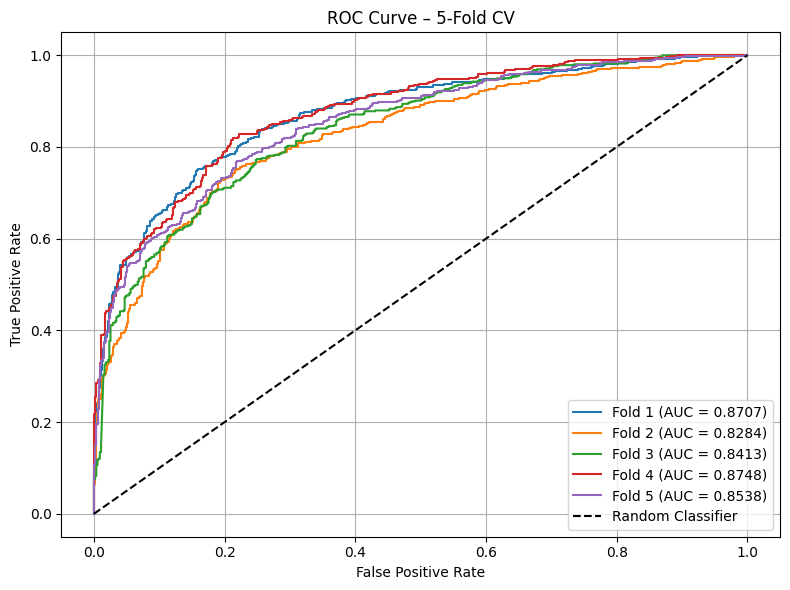

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


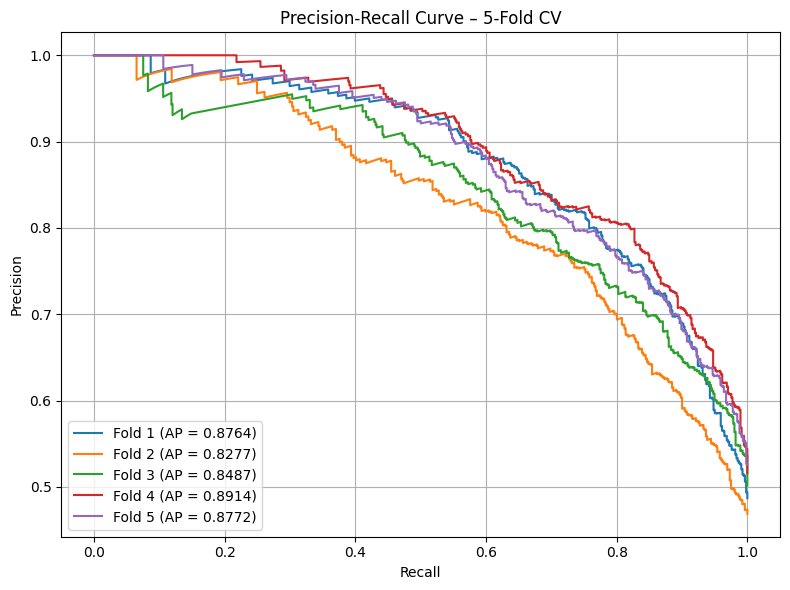

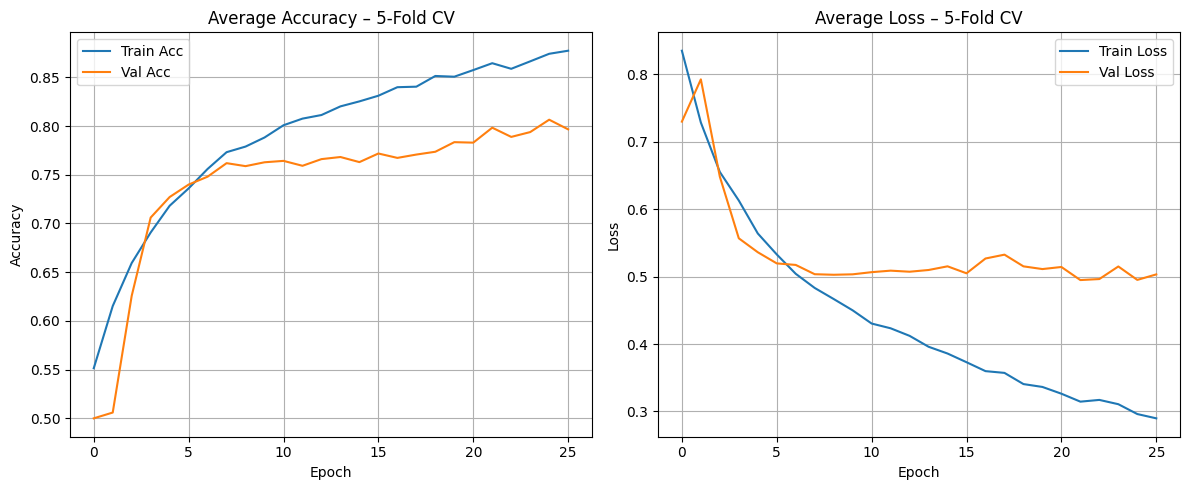


📊 Mean ± Std Evaluasi 5-Fold:
   Metric      Mean ± Std
     fold 3.0000 ± 1.5811
 accuracy 0.7749 ± 0.0155
precision 0.7911 ± 0.0218
   recall 0.7470 ± 0.0447
 f1_score 0.7677 ± 0.0236
      auc 0.8538 ± 0.0195


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from tensorflow.keras.models import load_model

avg_train_loss = []
avg_val_loss = []
avg_train_acc = []
avg_val_acc = []
model_template = "model_fold{}.h5"
all_auc = []
all_ap = []

# =========================
# 📈 ROC Curve per Fold
# =========================
plt.figure(figsize=(8, 6))
for i, val_idx in enumerate(val_idx_list):
    X_val_fold = X_train.iloc[val_idx].astype(np.float32)
    Y_val_fold = Y_train.iloc[val_idx].astype(np.float32)
    model_path = os.path.join(output_dir, model_template.format(i+1))
    model = load_model(model_path)
    Y_pred_probs = model.predict(X_val_fold).flatten()

    fpr, tpr, _ = roc_curve(Y_val_fold, Y_pred_probs)
    roc_auc = auc(fpr, tpr)
    all_auc.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curve – 5-Fold CV')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "roc_auc_kfold_all.png"))
plt.show()

# =========================
# 📉 PR Curve per Fold
# =========================
plt.figure(figsize=(8, 6))
for i, val_idx in enumerate(val_idx_list):
    X_val_fold = X_train.iloc[val_idx].astype(np.float32)
    Y_val_fold = Y_train.iloc[val_idx].astype(np.float32)
    model_path = os.path.join(output_dir, model_template.format(i+1))
    model = load_model(model_path)
    Y_pred_probs = model.predict(X_val_fold).flatten()

    precision, recall, _ = precision_recall_curve(Y_val_fold, Y_pred_probs)
    ap = average_precision_score(Y_val_fold, Y_pred_probs)
    all_ap.append(ap)
    plt.plot(recall, precision, label=f'Fold {i+1} (AP = {ap:.4f})')

plt.title('Precision-Recall Curve – 5-Fold CV')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pr_curve_kfold_all.png"))
plt.show()

# =============================
# 🔢 Rata-rata Loss & Acc
# =============================
history_df = pd.concat(all_history)
mean_metrics = history_df.groupby('epoch')[['loss', 'val_loss', 'accuracy', 'val_accuracy']].mean()
avg_train_loss = mean_metrics['loss']
avg_val_loss = mean_metrics['val_loss']
avg_train_acc = mean_metrics['accuracy']
avg_val_acc = mean_metrics['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(avg_train_acc, label='Train Acc')
plt.plot(avg_val_acc, label='Val Acc')
plt.title('Average Accuracy – 5-Fold CV')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avg_train_loss, label='Train Loss')
plt.plot(avg_val_loss, label='Val Loss')
plt.title('Average Loss – 5-Fold CV')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "avg_loss_acc_kfold.png"))
plt.show()

df_metrics = pd.DataFrame(scores, columns=['fold', 'accuracy', 'precision', 'recall', 'f1_score', 'auc'])
mean_vals = df_metrics.mean(numeric_only=True)
std_vals = df_metrics.std(ddof=1, numeric_only=True)

summary = pd.DataFrame({
    'Metric': mean_vals.index,
    'Mean ± Std': [f"{mean:.4f} ± {std:.4f}" for mean, std in zip(mean_vals, std_vals)]
})

print("\n📊 Mean ± Std Evaluasi 5-Fold:")
print(summary.to_string(index=False))

✅ Model loaded from: /home/g6523023/Percobaan Final/DL/hasil_dnn/Retraining_new/best_model_auc_0.8748.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

📊 Evaluation Metrics on Test Data:
Accuracy : 0.7817
Precision: 0.7958
Recall   : 0.7579
F1-Score : 0.7764
ROC-AUC  : 0.8626

💾 Final test metrics saved to: /home/g6523023/Percobaan Final/DL/hasil_dnn/Retraining_new/Testing/final_test_metrics.csv


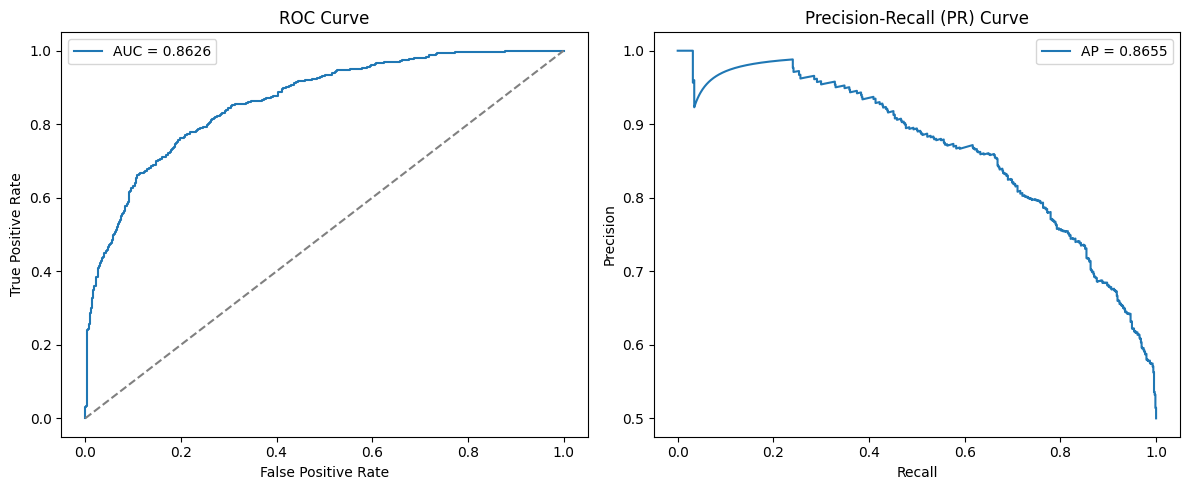

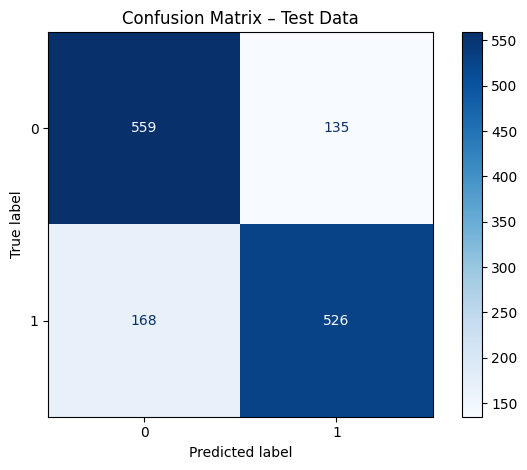

In [13]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, auc
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_path = '/home/g6523023/Percobaan Final/DL/hasil_dnn/Retraining_new/best_model_auc_0.8748.h5'
output_eval_path = '/home/g6523023/Percobaan Final/DL/hasil_dnn/Retraining_new/Testing/final_test_metrics.csv'
output_plot_dir = os.path.dirname(output_eval_path)
os.makedirs(output_plot_dir, exist_ok=True)

model = tf.keras.models.load_model(model_path)
print(f"✅ Model loaded from: {model_path}")

y_test_probs = model.predict(X_test.values.astype(np.float32)).flatten()
y_test_preds = (y_test_probs >= 0.5).astype(int)

acc = accuracy_score(Y_test, y_test_preds)
prec = precision_score(Y_test, y_test_preds)
rec = recall_score(Y_test, y_test_preds)
f1 = f1_score(Y_test, y_test_preds)
auc_roc = roc_auc_score(Y_test, y_test_probs)

print(f"\n📊 Evaluation Metrics on Test Data:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {auc_roc:.4f}")

results = pd.DataFrame({
    'Accuracy': [acc],
    'Precision': [prec],
    'Recall': [rec],
    'F1-Score': [f1],
    'ROC-AUC': [auc_roc]
})
results.to_csv(output_eval_path, index=False)
print(f"\n💾 Final test metrics saved to: {output_eval_path}")

# ===============================
# PLOT ROC & PR CURVE
# ===============================
fpr, tpr, _ = roc_curve(Y_test, y_test_probs)
prec_curve, recall_curve, _ = precision_recall_curve(Y_test, y_test_probs)
pr_auc = auc(recall_curve, prec_curve)

# ROC Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall_curve, prec_curve, label=f"AP = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (PR) Curve")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, 'final_test_roc_pr_curve.png'))
plt.show()

# ===============================
# CONFUSION MATRIX
# ===============================
cm = confusion_matrix(Y_test, y_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix – Test Data")
plt.tight_layout()
plt.savefig(os.path.join(output_plot_dir, "final_test_confusion_matrix.png"))
plt.show()